# TP1
# Utiliser ATOM

### Objectifs

Utiliser ATOM tel quel sans écrire de code. Manipuler / Vérifier les
traces

Documentation Atom : http://atom.univ-lille1.fr/AtomDoc.html  
Documentation R : https://www.r-project.org/manuals.html

**Connaissances préalables** : Un peu de Python

  Rappels :  
  - Le prix d'un ordre BID est un prix maximum (at worst)
  - le BID le plus élevé est prioritaire
  - Le prix d'un ordre ASK est un prix minimum (at least)
  - Le ASK le plus faible est prioritaire
  - Les ordres sont triés par prix, puis date
  - Quand une fixation est possible, c'est le prix du premier
    arrivé qui est utilisé

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import random
FILES = "files/"

from atom import *
from data_processing import *
import statsmodels.tsa.stattools as stats
plt.rcParams['figure.figsize'] = (15,10)

## 1 Expériences de fixation de prix

ATOM contient une commande `replay` qui permet d'exécuter une
série d'ordres. Tout agent cité dans ce fichier est
automatiquement créé avec cash et invests à 0. Tout asset cité
implique la création d'un orderbook pour son
traitement. `replay` est donc multi-agents et multi-carnets et
permet lors d'une exécution d'accéder à la richesse de trace d'ATOM (Order,Price, OrderBook, Agent,Exec,ticks,days)
```
m = Market(['LVMH'], trace=['price'], fix='S')  
m.replay('orderFileEx1.dat')  
m.print_state()  
```
**1. Regardez le fichier `orderFileEx1.dat`. La syntaxe des ordres est indiquée dedans. Combien de prix sont fixés ?**

In [2]:
m = Market(['LVMH'], trace=['price'], fix='S')
m.replay('orderFileEx1.dat')
m.print_state()

# Price;asset;bider;asker;price;qty;timestamp(µs)
Price;LVMH;1;1;45500;10;756224
Price;LVMH;1;1;45800;10;884736
Price;LVMH;1;1;42000;2;972032
Price;LVMH;1;1;42000;12;1030144
Price;LVMH;1;1;34000;18;1095168
Price;LVMH;1;1;34000;11;1188864
Price;LVMH;1;1;34000;5;1241856
# Nb orders received: 11
# Nb fixed prices: 7
# Leaving ask size: 0
# Leaving bid size: 0


**2. Modifiez la fixation de prix de short en long. Combien de prix sont fixés ?**

In [3]:
m = Market(['LVMH'], trace=['price'], fix='L')
m.replay('orderFileEx1.dat')
m.print_state()

# Price;asset;bider;asker;price;qty;timestamp(µs)
Price;LVMH;2;2;45500;10;922624
Price;LVMH;2;2;45800;10;1003264
Price;LVMH;2;2;45800;7;1047808
Price;LVMH;2;2;45500;3;1099264
Price;LVMH;2;2;42000;2;1132032
Price;LVMH;2;2;42000;12;1425920
Price;LVMH;2;2;34000;18;1469440
Price;LVMH;2;2;34000;11;1496832
Price;LVMH;2;2;34000;5;1515520
# Nb orders received: 11
# Nb fixed prices: 9
# Leaving ask size: 0
# Leaving bid size: 0


**3. Créez votre propre fichier contenant 3 limitOrders maxi, tous à des
  prix différents, et tels que tous les ordres soient exécutés
  complètement et que le nombre de prix fixés en `Short` et en
  `Long` soit différent**

In [4]:
file = open('myOrderFile.dat',"w")
file.write("""
NewAgent;paul;0;LVMH:0
NewAgent;alan;0;LVMH:0
NewAgent;bob;0;LVMH:0
LimitOrder;LVMH;paul;BID;110;1
LimitOrder;LVMH;bob;BID;120;1
LimitOrder;LVMH;alan;ASK;100;2
""")
file.close
print("Short")
m = Market(['LVMH'], trace=['price'],fix="S")
m.replay('myOrderFile.dat')
m.print_state()
print("\nLong")
m = Market(['LVMH'], trace=['price'],fix="L")
m.replay('myOrderFile.dat')
m.print_state()

# 2 en Long, 1 en Short
# Si on permute la dernière ligne en première position, ce n'est plus vrai !

Short
# Price;asset;bider;asker;price;qty;timestamp(µs)
# Nb orders received: 0
# Nb fixed prices: 0
# Leaving ask size: 0
# Leaving bid size: 0

Long
# Price;asset;bider;asker;price;qty;timestamp(µs)
# Nb orders received: 0
# Nb fixed prices: 0
# Leaving ask size: 0
# Leaving bid size: 0


**4. Donnez un fichier minimal d'ordres ne contenant qu'un seul ASK, et tel que 3 prix soient fixés en ordre décroissant**

In [5]:
file = open('myOrderFile.dat',"w")
file.write("""
NewAgent;alan;0;LVMH:0
NewAgent;bob;0;LVMH:0
LimitOrder;LVMH;bob;BID;110;1
LimitOrder;LVMH;bob;BID;120;1
LimitOrder;LVMH;bob;BID;130;1
LimitOrder;LVMH;alan;ASK;100;3
""")
file.close()
m = Market(['LVMH'], trace=['price'],fix="L")
m.replay('myOrderFile.dat')
m.print_state()


#  On note que ici c'est bob-3 qui est exécuté en premier, et bob-1 en 
#  dernier
#  On note aussi que les ordres sont placés de manière croissante !
#  Si on place le ASK en début de fichier, les 3 prix seront fixés à 100

# Price;asset;bider;asker;price;qty;timestamp(µs)
Price;LVMH;4;3;130;1;886016
Price;LVMH;4;3;120;1;921600
Price;LVMH;4;3;110;1;937728
# Nb orders received: 4
# Nb fixed prices: 3
# Leaving ask size: 0
# Leaving bid size: 0


**5. Donnez un fichier minimal d'ordres ne contenant qu'un seul ASK, et tel que 3 prix soient fixés en ordre croissant.**

 C'est IMPOSSIBLE :  
    Si le ask est en tête, c'est lui qui fournit le prix : tous les
    prix seront identiques.   
    Si le ask est en fin, les 3 bid arrivent donc avant, et seront
    ordonnés par prix croissant (le plus élevé en prioritaire), donc
    l'exécution donnera forcément
    des prix décroissants.   

## 2 Génération de prix

ATOM contient une commande `Generate` qui permet de créer des
séries de prix ou d'ordres à partir d'expériences simples utilisant
des Zero Intelligence Traders (ZIT1 à ZITn) générant chacun un ordre à
chaque tour. La génération d'une série d'ordres est immédiatement
exécutée fournissant ainsi une trace ATOM, reproductible par
`Replay`.

```
m.generate(<nb_ZIT>, <nb_turn>, <init_assets>, <init_cash>)
```
**1. Générez un fichier `myfile.dat` à 3 agents et 1 seul carnet d'ordres s'exécutant durant 100 tours de parole.**

In [6]:
file = open('myfile.dat', 'w')

m = Market(['Apple'], out=file)
m.generate(3, 100, 0, 0)
m.print_state()
traders_id = []
for trader in m.traders:
    traders_id.append(trader.trader_id)
file.close()



**2. A partir de `myfile.dat`, générez `myfile.orders.dat` et `myfile.prices.dat` contenant respectivement les ordres et les prix générés par cette expérience.**

In [7]:
orders = open("myfile.orders.dat","w")
prices = open("myfile.prices.dat","w")
myfile = open("myfile.dat","r")
line = myfile.readline()
while(line!=""):
    if line[0]!='#':
        if "Price;" in line:
            prices.write(line)
        elif "LimitOrder;" in line:
            orders.write(line)
    line = myfile.readline()
orders.close()
prices.close()
myfile.close()


**3. Combien y-a t-il d'ordres et de prix dans ces deux fichiers ?**

In [8]:
def count_lines(filename):
    file = open(filename,"r")
    line = file.readline()
    c=0
    while(line!=""):
        c+=1
        line = file.readline()
    return c
print("Nombre de prix :",count_lines("myfile.prices.dat"))
print("Nombre d'ordres :",count_lines("myfile.orders.dat"))

Nombre de prix : 210
Nombre d'ordres : 300


**4. Tracez la courbe d'évolution des prix de cette expérience**

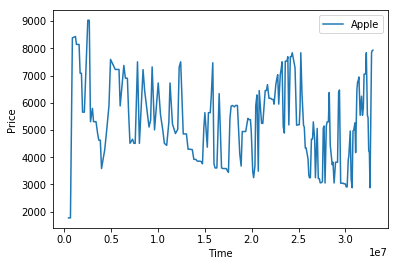

In [9]:
Prices = extract_prices('myfile.dat')
plt.plot(Prices["Apple"][0], Prices["Apple"][1], '-', label='Apple')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [10]:
prices = []
qty = []
vol = []

file = open('myfile.prices.dat', 'r')
file.readline()
line = file.readline()
while(line!=""):
    l = line.split(";")
    prices.append(int(l[4]))
    qty.append(int(l[5]))
    if(len(prices)>1):
        vol.append((prices[-2]-prices[-1])/prices[-1])
    line = file.readline()





**5. Tracez la série chronologique (barplot) d'évolution des quantités**

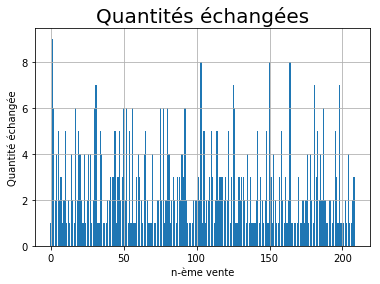

In [11]:
plt.bar([i for i in range(len(qty))],qty)
plt.title("Quantités échangées",{'fontsize': 20})
plt.grid()
plt.xlabel("n-ème vente")
plt.ylabel('Quantité échangée')
plt.show()

**4. Tracez la série chronologique (barplot) des volatilités (variation de prix en pourcentage)**

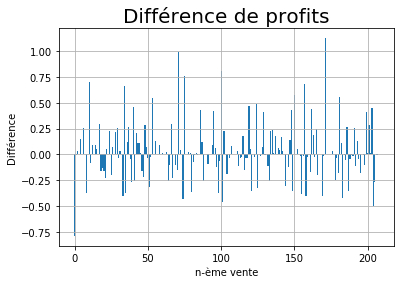

In [12]:
plt.bar([i for i in range(len(vol))],vol)
plt.title("Différence de profits",{'fontsize': 20})
plt.grid()
plt.xlabel("n-ème vente")
plt.ylabel('Différence')
plt.show()

**7. Tracez l'histogramme de distribution des volatilités**


**8. Comparez avec une gaussienne de même moyenne et écart-type**

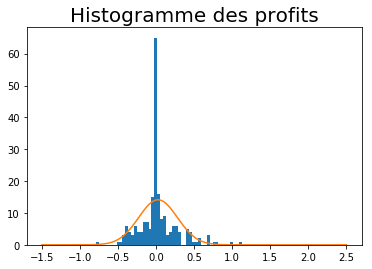

In [13]:
x = np.linspace(-1.5, 2.5, 1000)
mu = np.mean(vol)
sigma = np.std(vol)
y = (9 / (np.sqrt(2 * np.pi * np.power(sigma, 2)))) * \
    (np.power(np.e, -(np.power((x - mu), 2) / (2 * np.power(sigma, 2)))))
plt.hist(vol, bins=50)
plt.title("Histogramme des profits",{'fontsize': 20})
plt.plot(x, y);
plt.show()


## 3 Est-ce un cours vraisemblable ?

Sachant que la commande `Generate` utilise des agents ZIT dont chaque ordre envoyé est un ordre dont le prix est tiré uniformément entre 1000 et 9999 et la quantité entre 1 et 9. Refaire les mêmes
courbes mais avec des données purement aléatoires.

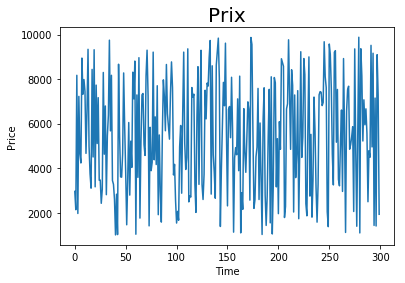

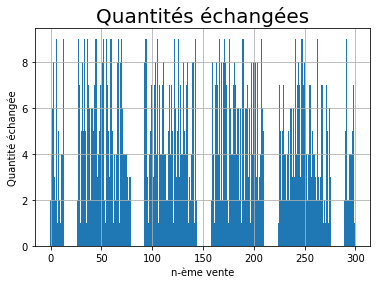

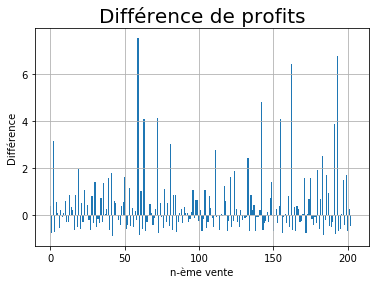

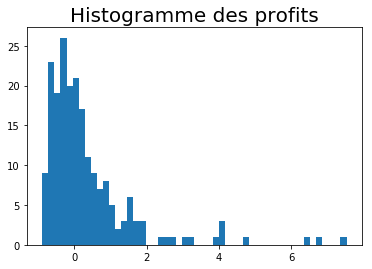

In [14]:
nb_ordres = 300
pricesR = [random.randint(1000,9999) for i in range(nb_ordres)]
qtyR = [random.randint(1,9) for i in range(nb_ordres)]
diffR = []

for i in range(1,206):
    diffR.append((pricesR[i-1]-pricesR[i])/pricesR[i])
    
plt.plot(pricesR)
plt.title("Prix",{'fontsize': 20})
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

plt.bar([i for i in range(len(qtyR))],qtyR)
plt.title("Quantités échangées",{'fontsize': 20})
plt.grid()
plt.xlabel("n-ème vente")
plt.ylabel('Quantité échangée')
plt.show()

plt.bar([i for i in range(len(diffR))],diffR)
plt.title("Différence de profits",{'fontsize': 20})
plt.grid()
plt.xlabel("n-ème vente")
plt.ylabel('Différence')
plt.show()

mR = np.mean(diffR)
sR = np.std(diffR)

#x = np.linspace(-0.04, 0.04, 100)
#y = scipy.stats.norm.pdf(x,m,s)
#plt.plot(y)
#plt.show()
plt.hist(diffR, bins=50)
plt.title("Histogramme des profits",{'fontsize': 20})
plt.show()

## 4 Évolution du portefeuille d'un agent
**1. Tracez l'évolution du cash du 3e agent issu de ce
  fichier. Chaque opération sur les avoirs d'un agent étant tracées
  dans une ligne `Agent`, cette courbe est facile à obtenir.**

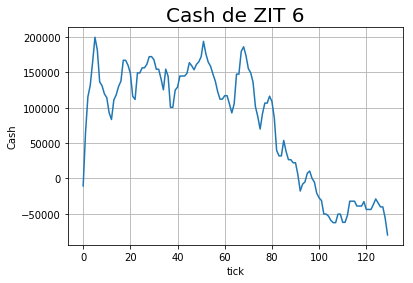

In [15]:
zitnames = ["ZIT "+str(id) for id in traders_id]

def extract_cash(filename,agent):
    cash = []
    file = open(filename,"r")
    line = file.readline()
    while(line!=""):
        if "Agent;"+agent in line and not "NewAgent" in line:
            cash.append(int(line.split(";")[2]))
        line = file.readline()
    file.close()
    return cash

cash = extract_cash('myfile.dat',zitnames[2])

plt.plot(cash)
plt.title("Cash de "+zitnames[2],{'fontsize': 20})
plt.grid()
plt.xlabel("tick")
plt.ylabel('Cash')
plt.show()

**2. Tracez l'évolution du portefeuille (wealth) de l'agent ZIT3 issu
  de ce fichier (facile car il y n'a qu'un seul asset)**

**3. Déterminez quel est celui des 3 agents qui s'en est sorti le
  mieux ? Est-ce que la somme des 3 valuations est nulle ?**

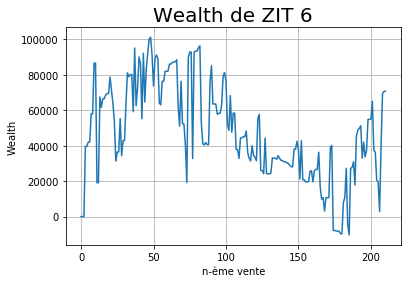

À la fin : 
ZIT 5 : 32371
ZIT 7 : -103146
ZIT 6 : 70775
Somme : 0


In [16]:
wealths = extract_wealths('myfile.dat')       

plt.plot(wealths[zitnames[2]][1])
plt.title("Wealth de "+zitnames[2],{'fontsize': 20})
plt.grid()
plt.xlabel("n-ème vente")
plt.ylabel('Wealth')
plt.show()


print("À la fin : ")

wealths_end = []
for i in range(3):
    wealths_end.append(wealths[zitnames[i]][1][-1])
    
for i in range(3):
    print(zitnames[i]+" : "+str(wealths_end[i]))

print("Somme :",sum(wealths_end))   

## 5 Comparer le wealth de plusieurs agents

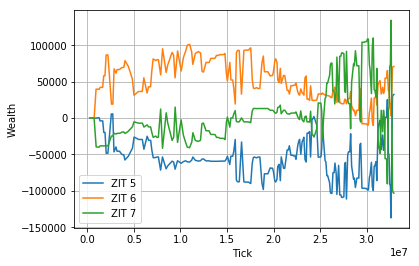

In [17]:
for agent in wealths.keys():
    T, W = wealths[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Tick')
plt.ylabel('Wealth')
plt.show()

## 6 Rejouer un fichier généré

Les fichiers obtenus avec `Generate` sont totalement
compatibles avec `Replay`. Ils peuvent donc être rejoués tels
quels sans aucun problème. Dans le cas d'un `Replay` d'un tel
fichier, seules les lignes `Orders` sont prises en compte. Les
autres lignes (Ticks ou commandes par exemple) sont simplement recopiées.


**1. Rejouez `myfile.dat` et affichez le résultat.**  
**2. Vérifiez que ce résultat correspond à `myfile.dat`**

_Problème de trace :  agents renommés, trace forcément affichée, jamais les ticks.._


In [18]:
m = Market(['Apple'])
m.replay('myfile.dat')
print("\nÉtat des traders à la fin : ")
for t in m.traders: # On parcourt l'ensemble des traders
    print("Agent "+t.get_infos(m))
#m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;8;0;Apple:0
AgentWealth;8;0;607488
NewAgent;9;0;Apple:0
AgentWealth;9;0;699136
NewAgent;10;0;Apple:0
AgentWealth;10;0;784640
LimitOrder;Apple;10;ASK;1771;7;829696
LimitOrder;Apple;9;BID;8561;6;879872
Price;Apple;9;10;1771;6;943872
Agent;10;10626;Apple;-6;984832
Agent;9;-10626;Apple;6;1022464
AgentWealth;8;0;1059840
AgentWealth;9;0;1097216
AgentWealth;10;0;1134080
LimitOrder;Apple;8;BID;1060;1;1179136
LimitOrder;Apple;10;BID;3061;7;1224192
Price;Apple;10;10;1771;1;1283584
Agent;10;10626;Apple;-6;1323264
AgentWealth;8;0;1361664
AgentWealth;9;0;1399296
AgentWealth;10;0;1436160
LimitOrder;Apple;9;BID;4873;2;1480448
LimitOrder;Apple;8;BID;8384;9;1526016
LimitOrder;Apple;9;ASK;3037;9;1572352
Price;Apple

**3. Afin de vérifier qu'ATOM n'a pas "triché", refaites la même
  expérience mais en ne reprenant que les ordres du fichier
  initial.**

  * Séparer le fichier `myfile` initial en deux fichiers
    `init.orders` et `init.prices`
  * Rejouez `init.orders` et ne conservez que les prix
    générés dans `final.prices`
  * comparez `init.prices` et `final.prices`
  
  _les fichiers ne sont pas identiques : pas de triche possible_